<a href="https://colab.research.google.com/github/Amit32624/dbpedia_prj/blob/master/clustering_word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import nltk
import re
from nltk.corpus import stopwords
import pandas as pd
from pandas import DataFrame, Series
import random
from gensim.models import Word2Vec
from nltk import word_tokenize
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
nltk.download("stopwords")
import os
SEED = 55
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/

In [3]:
from google.colab import files
uploaded = files.upload()

Saving med_devs_clean_data.csv to med_devs_clean_data.csv


In [4]:
df = pd.read_csv('med_devs_clean_data.csv')

In [5]:
df.head()

,Name,Description,Category
0,Implantable loop recorder,"An implantable loop recorder (ILR), also known...",Implants (medicine)
1,Health Canada,"Health Canada (HC; French: Santé Canada, SC) i...",Regulation of medical devices
2,Visual prosthesis,"A visual prosthesis, often referred to as a bi...","Implants (medicine),Neuroprosthetics"
3,Medical Devices Directive,The Medical Device Directive (Council Directiv...,Regulation of medical devices
4,Nasal spray,Nasal sprays are used to deliver medications l...,"Drug delivery devices,Nasal sprays"


In [6]:
df['Name'][36]

'Total Annihilation'

In [7]:
df['Description'][36]

'Total Annihilation is a real-time strategy video game created by Cavedog Entertainment, a sub-division of Humongous Entertainment, and was released on September 26, 1997 by GT Interactive for Microsoft Windows and Mac OS. Two expansion packs were released, The Core Contingency on April 28, 1998 and Battle Tactics on June 30. After the closure of the Cavedog Entertainment in 1999, the intellectual property fell to Infogrames (now Atari). Total Annihilation is no longer officially supported, due to the closure of Cavedog. Former lead designer Chris Taylor went on with Gas Powered Games to create Supreme Commander in 2007, considered the "spiritual successor" of Total Annihilation. The creators of XTA, a mod for Total Annihilation, independently developed the open-source 3D graphics Spring game engine. The Total Annihilation 3D project began in 2006. Other ex-members of Cavedog, including Total Annihilation\'s game engine developer Jon Mavor, later went on to develop Planetary Annihilati

In [8]:
df['Category'][36]

'Cyborgs in fiction'

In [9]:
from google.colab import files
uploaded = files.upload()

Saving med_equips_clean_data.csv to med_equips_clean_data.csv


In [10]:
df1 = pd.read_csv('med_equips_clean_data.csv')
df1.head(3)

,Name,Description,Category
0,Cephalometry,Cephalometry is the study and measurement of t...,Medical imaging
1,Cephalotribe,A cephalotribe was a medical instrument used i...,Surgical instruments
2,Implantable loop recorder,"An implantable loop recorder (ILR), also known...","Cardiac electrophysiology,Implants (medicine),..."


In [11]:
medical_data = pd.concat([df, df1], axis=0,ignore_index=True)
medical_data.shape

(1804, 3)

In [12]:
medical_data['text_data'] = medical_data['Name'].astype(str).str.cat(medical_data['Description'].astype(str).str.cat(medical_data['Category']), sep=',')
medical_data.head()

,Name,Description,Category,text_data
0,Implantable loop recorder,"An implantable loop recorder (ILR), also known...",Implants (medicine),"Implantable loop recorder,An implantable loop ..."
1,Health Canada,"Health Canada (HC; French: Santé Canada, SC) i...",Regulation of medical devices,"Health Canada,Health Canada (HC; French: Santé..."
2,Visual prosthesis,"A visual prosthesis, often referred to as a bi...","Implants (medicine),Neuroprosthetics","Visual prosthesis,A visual prosthesis, often r..."
3,Medical Devices Directive,The Medical Device Directive (Council Directiv...,Regulation of medical devices,"Medical Devices Directive,The Medical Device D..."
4,Nasal spray,Nasal sprays are used to deliver medications l...,"Drug delivery devices,Nasal sprays","Nasal spray,Nasal sprays are used to deliver m..."


In [13]:
medical_data.shape

(1804, 4)

In [14]:
med_data =medical_data.drop_duplicates(subset=['text_data'],ignore_index=True)

In [15]:
med_data.head(3)

,Name,Description,Category,text_data
0,Implantable loop recorder,"An implantable loop recorder (ILR), also known...",Implants (medicine),"Implantable loop recorder,An implantable loop ..."
1,Health Canada,"Health Canada (HC; French: Santé Canada, SC) i...",Regulation of medical devices,"Health Canada,Health Canada (HC; French: Santé..."
2,Visual prosthesis,"A visual prosthesis, often referred to as a bi...","Implants (medicine),Neuroprosthetics","Visual prosthesis,A visual prosthesis, often r..."


In [16]:
med_data.shape

(1500, 4)

In [17]:
type(med_data)
med_data.columns
med_data['text_data']

0       Implantable loop recorder,An implantable loop ...
1       Health Canada,Health Canada (HC; French: Santé...
2       Visual prosthesis,A visual prosthesis, often r...
3       Medical Devices Directive,The Medical Device D...
4       Nasal spray,Nasal sprays are used to deliver m...
                              ...                        
1495    Iohexol,Iohexol, sold under the trade name Omn...
1496    Iopanoic acid,Iopanoic acid is an iodine-conta...
1497    Iopydol,Iopydol is a pharmaceutical drug used ...
1498    Iotalamic acid,Iotalamic acid (USAN: iothalami...
1499    Ioxitalamic acid,Ioxitalamic acid (brand name ...
Name: text_data, Length: 1500, dtype: object

In [18]:
med_data.loc[0, "text_data"]

"Implantable loop recorder,An implantable loop recorder (ILR), also known as an insertable cardiac monitor (ICM), is a small device about the size of a pack of chewing gum or USB memory stick that is implanted just under the skin of the chest for cardiac monitoring (that is, to record the heart's electrical activity).Implants (medicine)"

In [19]:
# Removing of unwanted infromation

corpus =[]

for i in range(len(med_data['text_data'])):
    subject = med_data.loc[i, "text_data"]
    subject = subject.lower()
    subject = re.sub('[^a-zA-Z]',' ',subject)
    subject = re.sub(r"\s+", " ", subject)  # to  remove multiple spaces--
    subject = re.sub(r"\w+…|…", "", subject)  # to remove ellipsis--
    subject = re.sub(r"(?<=\w)-(?=\w)", " ", subject) # to  replace dash between words
    subject = subject.split()
    subject = [(word) for word in subject if not word in set(stopwords.words('english')+ ['used','use','using','also','may','known', 'one','two'] )] #To remove stop words
    subject =' '.join(subject)
    corpus.append(subject)

In [20]:
#Reading the processed data after removing noise.
corpus[0:2]

['implantable loop recorder implantable loop recorder ilr insertable cardiac monitor icm small device size pack chewing gum usb memory stick implanted skin chest cardiac monitoring record heart electrical activity implants medicine',
 'health canada health canada hc french sant canada sc department government canada responsible national health policy department responsible numerous federal health related agencies including canadian food inspection agency cfia public health agency canada phac among others organizations help ensure compliance federal law variety healthcare agricultural pharmaceutical activities responsibility involves extensive collaboration various federal provincial level organizations order ensure safety food health pharmaceutical products including regulation health research pharmaceutical manufacturing testing facilities department responsible parliament minister health presently patty hajdu part federal health portfolio deputy minister health senior civil servant w

In [21]:
# Tokenization of the text data
import nltk
nltk.download('punkt')
tokenized_data=[]
for i in range(len(corpus)):
  tokens = word_tokenize(str(corpus[i]))
  tokenized_data.append(tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [22]:
# Checking tokenized data
print(tokenized_data[0:2])

[['implantable', 'loop', 'recorder', 'implantable', 'loop', 'recorder', 'ilr', 'insertable', 'cardiac', 'monitor', 'icm', 'small', 'device', 'size', 'pack', 'chewing', 'gum', 'usb', 'memory', 'stick', 'implanted', 'skin', 'chest', 'cardiac', 'monitoring', 'record', 'heart', 'electrical', 'activity', 'implants', 'medicine'], ['health', 'canada', 'health', 'canada', 'hc', 'french', 'sant', 'canada', 'sc', 'department', 'government', 'canada', 'responsible', 'national', 'health', 'policy', 'department', 'responsible', 'numerous', 'federal', 'health', 'related', 'agencies', 'including', 'canadian', 'food', 'inspection', 'agency', 'cfia', 'public', 'health', 'agency', 'canada', 'phac', 'among', 'others', 'organizations', 'help', 'ensure', 'compliance', 'federal', 'law', 'variety', 'healthcare', 'agricultural', 'pharmaceutical', 'activities', 'responsibility', 'involves', 'extensive', 'collaboration', 'various', 'federal', 'provincial', 'level', 'organizations', 'order', 'ensure', 'safety', 

https://github.com/dylanjcastillo/nlp-snippets/blob/main/clustering/word2vec.ipynb

In [23]:
# Counting the number of vocab
from collections import Counter
docs = corpus
# tokenized_docs = all_keywords
tokenized_docs = tokenized_data
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [24]:
# Total number of vocabulary
len(vocab)

16846

In [25]:
# Most common words (Top ten)
vocab.most_common(10)


[('medical', 1202),
 ('imaging', 732),
 ('device', 514),
 ('devices', 413),
 ('brain', 385),
 ('medicine', 344),
 ('x', 338),
 ('surgical', 325),
 ('heart', 321),
 ('system', 312)]

In [26]:
#Installing word2vec module
!pip install word2vec


     |████████████████████████████████| 42 kB 933 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156423 sha256=efabe85223b3f6b5b819a4976028f681560239df7f1ec3c7718ed86788f85f1b
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [33]:
#Building model using word2vec
# SEED =42
from gensim.models import Word2Vec
Word2Vecmodel = Word2Vec(sentences=tokenized_data, workers=1)

In [34]:
words = list(Word2Vecmodel.wv.vocab)
print(words)

['implantable', 'loop', 'recorder', 'cardiac', 'monitor', 'small', 'device', 'size', 'memory', 'stick', 'implanted', 'skin', 'chest', 'monitoring', 'record', 'heart', 'electrical', 'activity', 'implants', 'medicine', 'health', 'canada', 'french', 'department', 'government', 'responsible', 'national', 'policy', 'numerous', 'federal', 'related', 'agencies', 'including', 'canadian', 'food', 'inspection', 'agency', 'public', 'among', 'others', 'organizations', 'help', 'ensure', 'compliance', 'law', 'variety', 'healthcare', 'pharmaceutical', 'activities', 'involves', 'extensive', 'collaboration', 'various', 'level', 'order', 'safety', 'products', 'regulation', 'research', 'manufacturing', 'testing', 'facilities', 'minister', 'part', 'within', 'day', 'leadership', 'operations', 'reports', 'directly', 'originally', 'created', 'spanish', 'flu', 'today', 'formed', 'former', 'established', 'split', 'separate', 'units', 'human', 'resources', 'medical', 'devices', 'visual', 'prosthesis', 'often', 

In [36]:
# Checking for the  word similarity to any random word
Word2Vecmodel.wv.most_similar("device")

[('products', 0.9998086094856262),
 ('care', 0.9997968673706055),
 ('health', 0.9997721910476685),
 ('designed', 0.9997619390487671),
 ('first', 0.9997590184211731),
 ('treatment', 0.9997550845146179),
 ('instrument', 0.9997549057006836),
 ('pump', 0.9997516870498657),
 ('various', 0.9997455477714539),
 ('patients', 0.9997431039810181)]

In [37]:
# Transofrming the tokenized words into vectors
import numpy as np
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
# vectorized_docs = vectorize(all_keywords, model=model)
vectorized_docs = vectorize(tokenized_data, model=Word2Vecmodel)
len(vectorized_docs), len(vectorized_docs[0])

(1500, 100)

# **Implementation of K-means algorithm** 




In [38]:
from sklearn.cluster import KMeans
sil = []
wcss = []
# 'cl_num' is the number of clusters
#  it is completely arbitrary.
cl_num = 13
for i in range(2,cl_num):
    
    knn_model = KMeans(n_clusters=i, init="k-means++", max_iter=100, n_init=1)
    
    knn_model.fit(vectorized_docs)
    
    wcss.append(knn_model.inertia_)
    labels = knn_model.labels_
    sil.append(silhouette_score(vectorized_docs, labels, metric = 'euclidean'))

Text(0, 0.5, 'WCSS: Within-cluster Sum of Squares')

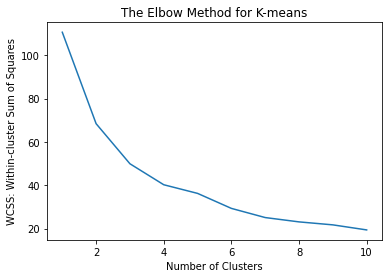

In [39]:
# Plot the number of clusters vs WCSS
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score



number_clusters = range(1,11)
plt.plot(number_clusters,wcss[0:10])
plt.title('The Elbow Method for K-means')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS: Within-cluster Sum of Squares')

Text(0, 0.5, 'Silhouette score')

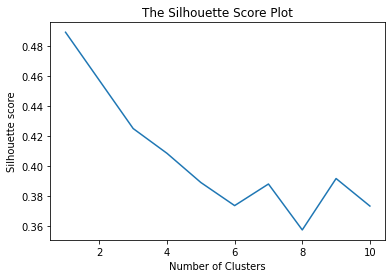

In [40]:
# Plot solhouette score
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score



number_clusters = range(1,11)
plt.plot(number_clusters,sil[0:10])
plt.title('The Silhouette Score Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')

In [34]:
# ordered_vocab = [(term, voc.index, voc.count) for term, voc in Word2Vecmodel.wv.vocab.items()]
# ordered_vocab = sorted(ordered_vocab, key=lambda k: k[2])
# ordered_terms, term_indices, term_counts = zip(*ordered_vocab)
# word_vectors = pd.DataFrame(Word2Vecmodel.wv.vectors[term_indices, :], index=ordered_terms)
# # word_vectors = word_vectors.T

In [43]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.metrics as metrics
wcss = []
for i in range(3,15):
    labels=KMeans(n_clusters=i,init="k-means++",random_state=200).fit(vectorized_docs).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(vectorized_docs,labels,metric="euclidean",sample_size=1000,random_state=200)))
    

Silhouette score for k(clusters) = 3 is 0.45254156
Silhouette score for k(clusters) = 4 is 0.42741245
Silhouette score for k(clusters) = 5 is 0.40810645
Silhouette score for k(clusters) = 6 is 0.39215
Silhouette score for k(clusters) = 7 is 0.39907324
Silhouette score for k(clusters) = 8 is 0.39327344
Silhouette score for k(clusters) = 9 is 0.40352488
Silhouette score for k(clusters) = 10 is 0.3756152
Silhouette score for k(clusters) = 11 is 0.38094214
Silhouette score for k(clusters) = 12 is 0.35708213
Silhouette score for k(clusters) = 13 is 0.37550783
Silhouette score for k(clusters) = 14 is 0.35111946


For n_clusters = 3 The average silhouette_score is : 0.45254156
For n_clusters = 4 The average silhouette_score is : 0.42741245
For n_clusters = 5 The average silhouette_score is : 0.40810645
For n_clusters = 6 The average silhouette_score is : 0.39215
For n_clusters = 7 The average silhouette_score is : 0.39907324
For n_clusters = 8 The average silhouette_score is : 0.39327344
For n_clusters = 9 The average silhouette_score is : 0.40352488
For n_clusters = 10 The average silhouette_score is : 0.3756152


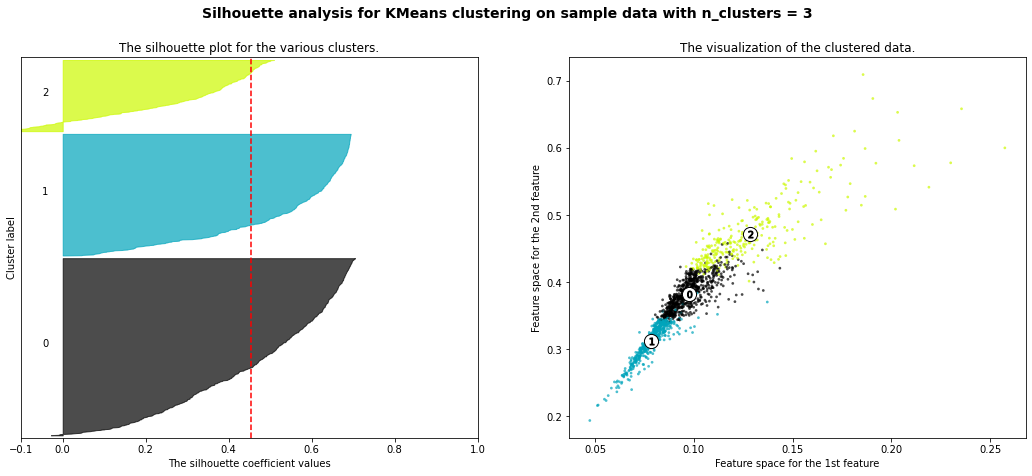

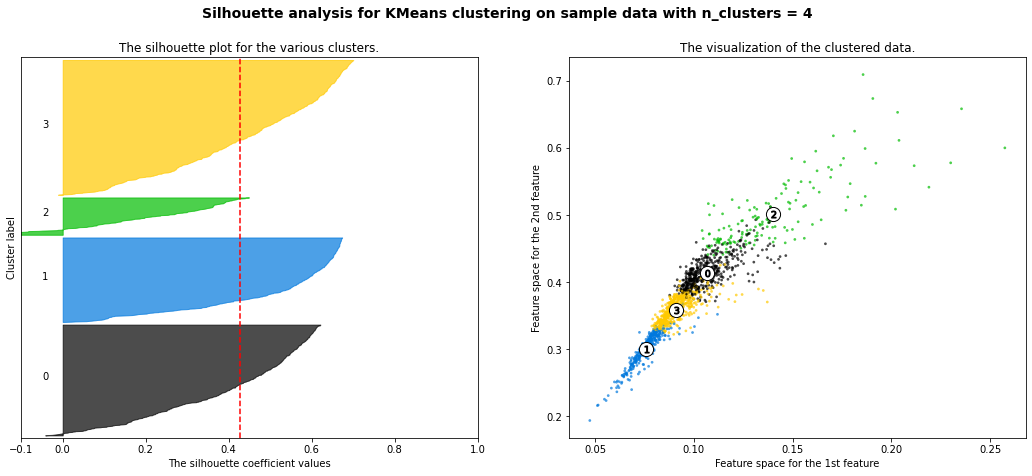

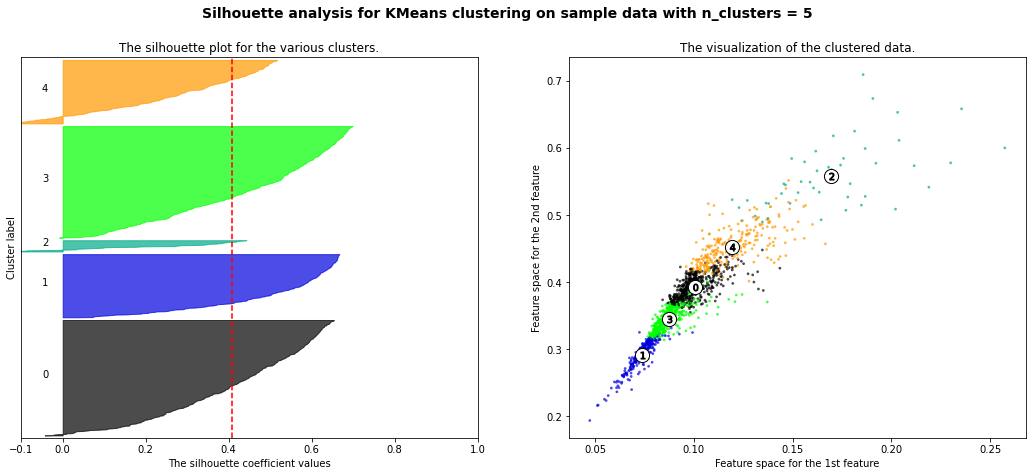

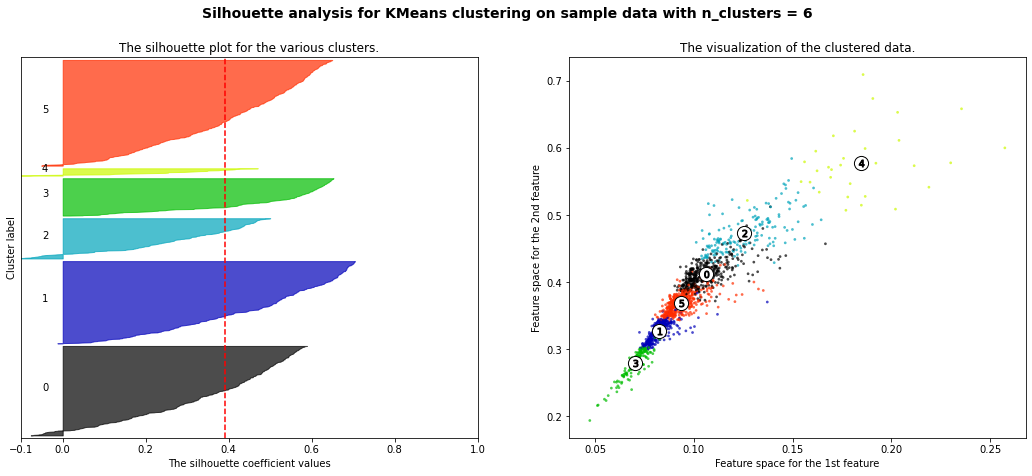

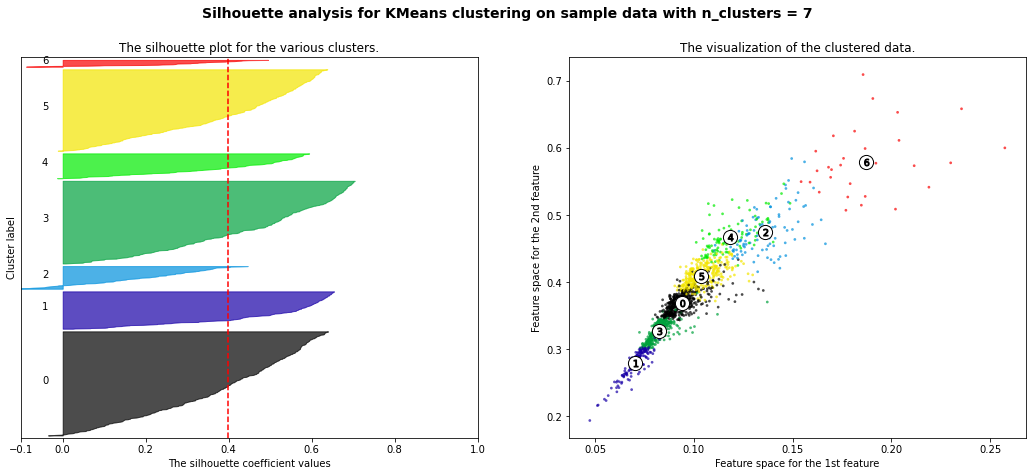

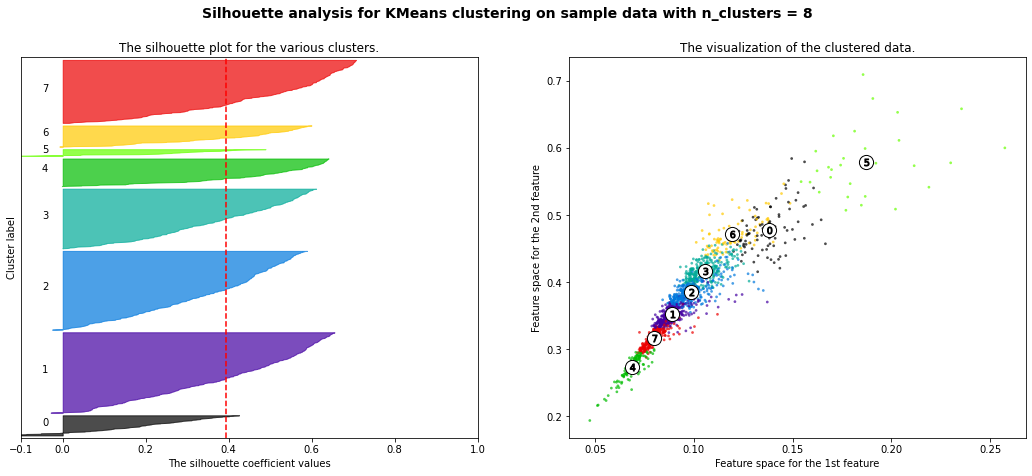

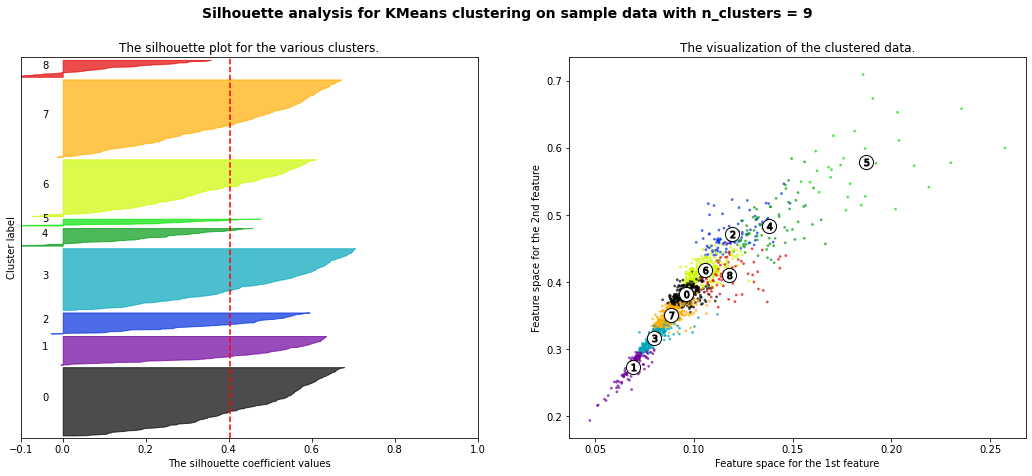

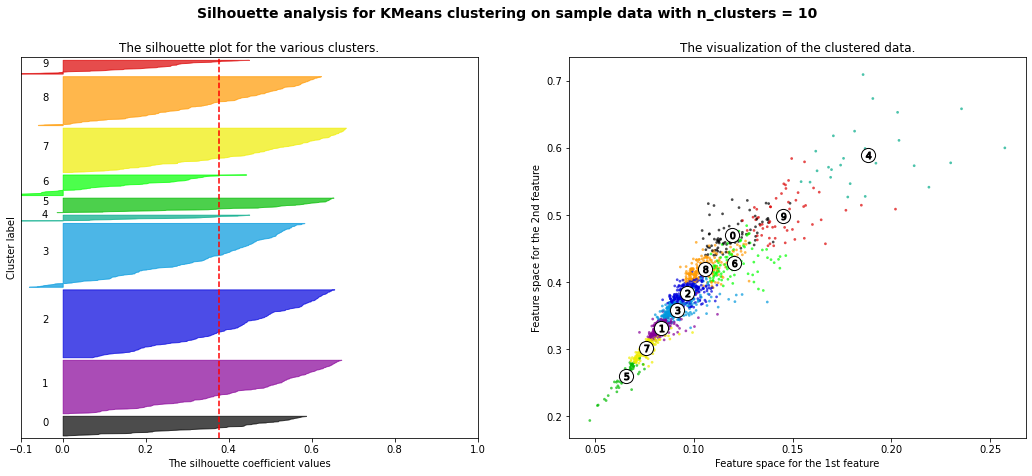

In [44]:


X = np.array(vectorized_docs)
range_n_clusters = [3,4,5,6,7,8,9,10]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,init="k-means++", random_state=200)
    cluster_labels = clusterer.fit_predict(X)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels,metric='euclidean',sample_size=1000,random_state=200)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

################BELOW

In [36]:
# SEED =42
# from gensim.models import Word2Vec
# model = Word2Vec(sentences=tokenized_data, workers=1, seed=SEED)


In [45]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
def mbkmeans_clusters(
	X, 
    k, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=10).fit(X)
    # km = KMeans(n_clusters=k,init="k-means++", random_state=200).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [38]:
print(len(med_data['text_data'].values))
print(len(tokenized_data))
print(len(cluster_labels))
print(len(vectorized_docs))

1500
1500
1500
1500


In [49]:


docs = med_data['text_data'].values
clustering, cluster_labels = mbkmeans_clusters(
	X=np.array(vectorized_docs),
    k=20,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 20
Silhouette coefficient: 0.25
Inertia:20.503173828125
Silhouette values:
    Cluster 6: Size:150 | Avg:0.41 | Min:-0.25 | Max: 0.65
    Cluster 14: Size:59 | Avg:0.40 | Min:0.07 | Max: 0.57
    Cluster 12: Size:221 | Avg:0.38 | Min:-0.32 | Max: 0.64
    Cluster 5: Size:155 | Avg:0.36 | Min:-0.26 | Max: 0.59
    Cluster 11: Size:59 | Avg:0.36 | Min:-0.28 | Max: 0.58
    Cluster 10: Size:11 | Avg:0.30 | Min:-0.04 | Max: 0.52
    Cluster 7: Size:97 | Avg:0.27 | Min:-0.21 | Max: 0.53
    Cluster 16: Size:87 | Avg:0.24 | Min:-0.15 | Max: 0.47
    Cluster 0: Size:50 | Avg:0.22 | Min:-0.07 | Max: 0.43
    Cluster 3: Size:162 | Avg:0.20 | Min:-0.20 | Max: 0.49
    Cluster 17: Size:60 | Avg:0.18 | Min:-0.18 | Max: 0.43
    Cluster 8: Size:19 | Avg:0.16 | Min:-0.19 | Max: 0.43
    Cluster 15: Size:50 | Avg:0.14 | Min:-0.37 | Max: 0.45
    Cluster 2: Size:12 | Avg:0.13 | Min:-0.14 | Max: 0.37
    Cluster 19: Size:46 | Avg:0.13 | Min:-0.23 | Max: 0.39
    Cluster 18: Size:52 | A

In [50]:
df_clusters
print(df_clusters['text'][0])
print(df_clusters['tokens'][0])

Implantable loop recorder,An implantable loop recorder (ILR), also known as an insertable cardiac monitor (ICM), is a small device about the size of a pack of chewing gum or USB memory stick that is implanted just under the skin of the chest for cardiac monitoring (that is, to record the heart's electrical activity).Implants (medicine)
implantable loop recorder implantable loop recorder ilr insertable cardiac monitor icm small device size pack chewing gum usb memory stick implanted skin chest cardiac monitoring record heart electrical activity implants medicine


In [41]:
df_clusters.head()

,text,tokens,cluster
0,"Implantable loop recorder,An implantable loop ...",implantable loop recorder implantable loop rec...,9
1,"Health Canada,Health Canada (HC; French: Santé...",health canada health canada hc french sant can...,3
2,"Visual prosthesis,A visual prosthesis, often r...",visual prosthesis visual prosthesis often refe...,11
3,"Medical Devices Directive,The Medical Device D...",medical devices directive medical device direc...,17
4,"Nasal spray,Nasal sprays are used to deliver m...",nasal spray nasal sprays deliver medications l...,19


In [42]:
Word2Vecmodel.wv.most_similar(positive=[clustering.cluster_centers_[2]], topn=5)

[('imaging', 0.9986384510993958),
 ('mri', 0.9958404302597046),
 ('nmr', 0.9923702478408813),
 ('elastography', 0.9920657873153687),
 ('cmr', 0.9919242858886719)]

Evaluate top terms per cluster (based on clusters' centroids)

In [43]:
print("Most representative terms per cluster (based on centroids):")
for i in range(20):
    tokens_per_cluster = ""
    most_representative = Word2Vecmodel.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: including provides applied information developed 
Cluster 1: uses image scanning scanner scan 
Cluster 2: imaging mri nmr elastography cmr 
Cluster 3: including provides applied national created 
Cluster 4: contrast scanners medium pet optical 
Cluster 5: including provides systems applied data 
Cluster 6: contrast medium scanners coherence radiography 
Cluster 7: many available include commonly since 
Cluster 8: radiography medium beam scanning radiocontrast 
Cluster 9: work group various many designed 
Cluster 10: various due available include work 
Cluster 11: work various products provides due 
Cluster 12: either although type allow thus 
Cluster 13: provides including developed products information 
Cluster 14: spectroscopy technique functional techniques vivo 
Cluster 15: functional fmri spectroscopy vivo modalities 
Cluster 16: technique techniques field neuroimaging microscopy 
Cluster 17: work various due m

Evaluate top terms per cluster (based on words frequencies)

In [44]:
for i in range(20):
    tokens_per_cluster = ""
    most_frequent = Counter(" ".join(df_clusters.query(f"cluster == {i}")["tokens"]).split()).most_common(5)
    for t in most_frequent:
        tokens_per_cluster += f"{t[0]}({str(t[1])}) "
    print(f"Cluster {i}: {tokens_per_cluster}")

Cluster 0: snyder(16) alita(15) medical(14) justice(14) battle(13) 
Cluster 1: imaging(81) medical(52) tomography(48) x(42) ray(32) 
Cluster 2: imaging(32) magnetic(28) resonance(26) medical(9) mri(6) 
Cluster 3: medical(125) surgical(63) devices(49) patients(49) patient(45) 
Cluster 4: imaging(65) x(46) ray(36) tomography(35) contrast(26) 
Cluster 5: medical(68) brain(48) device(36) devices(36) patient(36) 
Cluster 6: x(92) ray(71) ct(32) tomography(27) imaging(25) 
Cluster 7: ethylene(8) arch(8) p(6) lawwill(6) exponential(6) 
Cluster 8: x(57) ray(45) image(19) radiography(19) beam(17) 
Cluster 9: medical(53) radiation(39) brain(34) implants(32) device(31) 
Cluster 10: medical(71) device(35) devices(31) game(26) university(24) 
Cluster 11: medical(186) device(103) heart(81) devices(75) surgical(58) 
Cluster 12: medical(62) ion(60) potential(54) membrane(53) device(49) 
Cluster 13: medical(141) radiation(76) device(59) potential(57) devices(55) 
Cluster 14: imaging(55) mri(34) magneti

Retrieve most representative documents (based on clusters' centroids)

In [45]:
test_cluster = 6
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:5]:
    print(docs[d])
    print("-------------")

CT scan,A CT scan or computed tomography scan (formerly known as computed axial tomography or CAT scan) is a medical imaging technique used in radiology to get detailed images of the body noninvasively for diagnostic purposes. The personnel that perform CT scans are called radiographers or radiology technologists. CT scanners use a rotating x-ray tube and a row of detectors placed in the gantry to measure X-ray attenuations by different tissues inside the body. The multiple X-ray measurements taken from different angles are then processed on a computer using reconstruction algorithms to produce tomographic (cross-sectional) images (virtual "slices") of a body. The use of ionizing radiations sometimes restricts its use owing to its adverse effects. However, CT can be used in patients with metallic implants or pacemakers where MRI is contraindicated. Since its development in the 1970s, CT has proven to be a versatile imaging technique. While CT is most prominently used in diagnostic medi

Retrieve a random sample of documents for a given cluster

In [46]:
for i,t in enumerate(df_clusters.query(f"cluster == {test_cluster}").sample(4).iterrows()):
    print(t[1]["text"])
    print("-------------")

Ioglicic acid,Ioglicic acid is a pharmaceutical drug that was used as an iodinated contrast medium for X-ray imaging, in form of its salt meglumine ioglicate. Uses included imaging of the brain, the aorta and femoral arteries, and the urinary system (an examination called intravenous urography). It is not known to be marketed anywhere in the world in 2021.Radiocontrast agents
-------------
Limited radiology technician,Limited Radiology Technicians perform X-rays of patients and deliver the images to doctors. They make no diagnosis but still work closely with patients, explaining procedures, operating the X-ray and other associated equipment. Technical aspects include positioning patients for X-rays, determining appropriate angle and height of X-ray equipment, and calculating radiation dosages needed to create X-rays of the appropriate density, detail, and contrast, enabling the physician to make an accurate diagnosis.Radiology
-------------
Bronchography,Bronchography is a radiological

# FOR SINGLE CLUSTER

In [30]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
def mbkmeans_clusters(
	X, 
    k, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km =  KMeans(n_clusters=k, init="k-means++", max_iter=100, n_init=1).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")
    print(f"Silhouette values:")

    return km, km.labels_

In [31]:
import os
import random
SEED = 55
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)


docs = med_data['Category'].values
docs1 = med_data['Name'].values
clustering, cluster_labels = mbkmeans_clusters(
	X=np.array(vectorized_docs),
    k=6,
    print_silhouette_values=True,
)
df_cluster = pd.DataFrame({
    "Name": docs1,
    "category":docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 6
Silhouette coefficient: 0.39
Inertia:33.69727006267847
Silhouette values:


In [32]:
df_cluster.head()

,Name,category,tokens,cluster
0,Implantable loop recorder,Implants (medicine),implantable loop recorder implantable loop rec...,1
1,Health Canada,Regulation of medical devices,health canada health canada hc french sant can...,3
2,Visual prosthesis,"Implants (medicine),Neuroprosthetics",visual prosthesis visual prosthesis often refe...,3
3,Medical Devices Directive,Regulation of medical devices,medical devices directive medical device direc...,3
4,Nasal spray,"Drug delivery devices,Nasal sprays",nasal spray nasal sprays deliver medications l...,5


In [33]:
# df_cluster.groupby('cluster').
df_cluster.sort_values(by=['cluster'])

,Name,category,tokens,cluster
951,Orthotics,Orthopedic braces,orthotics orthotics greek romanized ortho lit ...,0
872,Mercury swivel commutator,Electrophysiology,mercury swivel commutator mercury swivel commu...,0
868,FitzHugh–Nagumo model,Electrophysiology,fitzhugh nagumo model fitzhugh nagumo model fh...,0
180,Toothpaste,Drug delivery devices,toothpaste toothpaste paste gel dentifrice too...,0
843,Quad helix,"Dental equipment,Orthodontic appliances",quad helix quad helix quadhelix orthodontic ap...,0
...,...,...,...,...
643,Bogota bag,Surgical instruments,bogota bag bogota bag sterile plastic bag clos...,5
648,Mandibular advancement splint,Dental equipment,mandibular advancement splint mandibular splin...,5
1136,PFA-100,Medical testing equipment,pfa pfa platelet function assay platelet funct...,5
244,Tuberous breasts,Implants (medicine),tuberous breasts tuberous breasts tubular brea...,5


In [34]:
df_cluster1 =df_cluster[df_cluster['cluster'] ==0]
df_cluster2 =df_cluster[df_cluster['cluster'] ==1]
df_cluster3 =df_cluster[df_cluster['cluster'] ==2]
df_cluster4 =df_cluster[df_cluster['cluster'] ==3]
df_cluster5 =df_cluster[df_cluster['cluster'] ==4]
df_cluster6 =df_cluster[df_cluster['cluster'] ==5]
df_cluster7 =df_cluster[df_cluster['cluster'] ==6]



In [35]:
df_cluster1['category'].value_counts()

Biomaterials                 15
Medical illustrators         15
Radiologic signs             12
Cyborgs in fiction           12
Mobility devices             10
                             ..
Medical transport devices     1
Prosthetic manufacturers      1
Surgical scissors             1
Fictional radiologists        1
Medical pumps                 1
Name: category, Length: 61, dtype: int64

In [42]:
df_cluster2['category'].value_counts()

Medical imaging                                                                            19
Radiation therapy                                                                          11
Radiocontrast agents                                                                        9
Implants (medicine)                                                                         8
Radiography                                                                                 6
Medical device manufacturers                                                                6
Medical devices                                                                             4
Magnetic resonance imaging                                                                  3
Radiologic signs                                                                            3
Nuclear medicine                                                                            3
Cardiac electrophysiology                                   

In [43]:
df_cluster3['category'].value_counts()

Electrophysiology                                                 28
Medical imaging                                                   22
Implants (medicine)                                               19
Medical ultrasonography                                           12
Radiation therapy                                                 11
                                                                  ..
Breast imaging                                                     1
Cardiac electrophysiology,Implants (medicine),Neuroprosthetics     1
Magnetic resonance imaging,Neuroimaging                            1
Cyborgs in fiction                                                 1
Nuclear medicine,Radiation therapy                                 1
Name: category, Length: 100, dtype: int64

In [44]:
df_cluster4['category'].value_counts()

Electrophysiology                                                  25
Implants (medicine)                                                24
Drug delivery devices                                              16
Medical imaging                                                    16
Medical ultrasonography                                            14
                                                                   ..
Drug delivery devices,Medical pumps                                 1
Cardiac electrophysiology,Medical devices                           1
Biomaterials,Surgical instruments                                   1
Brain–computer interfacing,Implants (medicine),Neuroprosthetics     1
Biomaterials,Drug delivery devices                                  1
Name: category, Length: 114, dtype: int64

In [45]:
df_cluster5['category'].value_counts()

Magnetic resonance imaging                              7
Radiocontrast agents                                    5
Medical imaging                                         4
MRI contrast agents                                     2
X-ray computed tomography                               2
Contrast agents                                         1
Respiratory system imaging,X-ray computed tomography    1
Tomography                                              1
Magnetic resonance imaging,Medical imaging,Radiology    1
Radiology organizations                                 1
Digestive system imaging,Magnetic resonance imaging     1
Nuclear medicine                                        1
Cardiac imaging,Magnetic resonance imaging              1
Magnetic resonance imaging,Neuroimaging                 1
Name: category, dtype: int64

In [46]:
df_cluster6['category'].value_counts()

Drug delivery devices                                   31
Implants (medicine)                                     21
Electrophysiology                                       15
Biomaterials                                            14
Cyborgs in fiction                                      11
                                                        ..
Radiography,Radiology organizations                      1
Mobility devices,Wheelchairs                             1
Orthopedic implants                                      1
Boston Scientific people                                 1
Implants (medicine),Medical devices,Neuroprosthetics     1
Name: category, Length: 100, dtype: int64

In [47]:
for i in range(6):
    print("Cluster:", i)
    print("The Members:", ' | '.join(list(df_cluster[df_cluster['cluster'] == i]['category'].values)))
    print("Total Members:", len(list(df_cluster[df_cluster['cluster'] == i]['category'].values)))
    print()

Cluster: 0
The Members: Mobility devices | Biomaterials | Biomaterials | Cyborgs | Biomaterials | Biomaterials | Nasal sprays | Cyborgs in fiction | Boston Scientific people | Cyborgs in fiction | Medical device manufacturers | Tinctures | Tinctures | Wheelchairs | Neuroprosthetics | Mobility devices,Wheelchairs | Cyborgs in fiction | Prosthetic manufacturers | Brain–computer interfacing | Medical device manufacturers | Drug delivery devices | Implants (medicine) | Biomaterials | Biomaterials | Biomaterials | Mobility devices | Cyborgs in fiction | Cyborgs in fiction | Implants (medicine) | Drug delivery devices | Mobility devices | Biomaterials | Cyborgs in fiction | Wheelchairs | Implants (medicine) | Cyborgs | Biomaterials | Cyborgs | Tinctures | Biomaterials | Cyborgs in fiction | Medical device manufacturers | Biomaterials | Mobility devices | Orthopedic implants | Biomaterials | Cyborgs in fiction | Wheelchairs | Drug delivery devices | Medical transport devices | Mobility device

In [61]:
for i in range(6):
    tokens_per_cluster = ""
    most_frequent = Counter(" ".join(df_cluster.query(f"cluster == {i}")["tokens"]).split()).most_common(5)
    for t in most_frequent:
        tokens_per_cluster += f"{t[0]}({str(t[1])}) "
    print(f"Cluster {i}: {tokens_per_cluster}")

Cluster 0: medical(78) device(41) devices(34) first(29) university(26) 
Cluster 1: imaging(152) medical(147) x(111) ray(84) radiation(67) 
Cluster 2: medical(372) imaging(258) device(159) heart(136) devices(125) 
Cluster 3: medical(417) imaging(176) device(171) surgical(145) devices(132) 
Cluster 4: imaging(69) magnetic(39) resonance(37) contrast(19) x(18) 
Cluster 5: medical(171) device(99) brain(92) devices(91) first(76) 


In [ ]:
docs

In [72]:
test_cluster = 1
most_rep_categories = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_rep_categories[:10]:
    print(docs1[d],"--",docs[d])
    print("-------------")

Viatronix -- Medical imaging
-------------
Spectronic -- Medical imaging
-------------
Life Image -- Medical imaging
-------------
Stereotaxis -- Medical devices,Surgical robots
-------------
Medical ultrasound -- Medical imaging,Medical ultrasonography
-------------
Machlett Laboratories -- Medical imaging
-------------
Biomedical Systems -- Medical imaging
-------------
Mefway (18F) -- PET radiotracers
-------------
INFINITT Healthcare -- Medical imaging
-------------
11C-UCB-J -- PET radiotracers
-------------


In [64]:
for i,t in enumerate(df_cluster.query(f"cluster == {test_cluster}").sample(6).iterrows()):
    print(t[1]["Name"])
    print("-------------")

Spike directivity
-------------
Inhaler
-------------
Optogenetics
-------------
Computer-aided diagnosis
-------------
Adhesion barrier
-------------
Bandage
-------------


## Implemenation of  K-mediods
https://analyticsindiamag.com/comprehensive-guide-to-k-medoids-clustering-algorithm/

In [51]:
!pip install scikit-learn-extra

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 22.3 MB 60.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [52]:
from sklearn_extra.cluster import KMedoids
sil =[]
wcss = []
# 'cl_num' is the number of clusters
#  it is completely arbitrary.
cl_num = 20
for i in range(2,cl_num):
    
    kmedoids = KMedoids(n_clusters=i, random_state=0,metric='euclidean', init='heuristic')
    
    kmedoids.fit(vectorized_docs)
    
    wcss.append(kmedoids.inertia_)
    labels = kmedoids.labels_
    sil.append(silhouette_score(vectorized_docs, labels, metric = 'euclidean'))

Text(0, 0.5, 'WCSS: Within-cluster Sum of Squares')

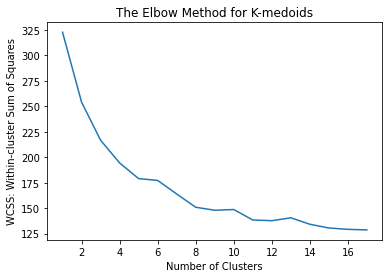

In [53]:
# Plot the number of clusters vs WCSS
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score



number_clusters = range(1,18)
plt.plot(number_clusters,wcss[0:17])
plt.title('The Elbow Method for K-medoids')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS: Within-cluster Sum of Squares')

Text(0, 0.5, 'Silhouette score')

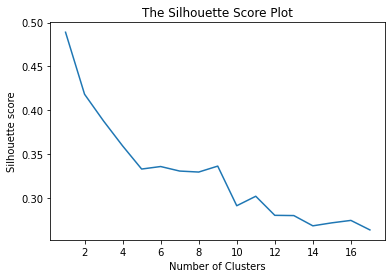

In [54]:
# Plot solhouette score
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score



number_clusters = range(1,18)
plt.plot(number_clusters,sil[0:17])
plt.title('The Silhouette Score Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')

For n_clusters = 3 The average silhouette_score is : 0.25528884
For n_clusters = 4 The average silhouette_score is : 0.26485962
For n_clusters = 5 The average silhouette_score is : 0.27540472
For n_clusters = 6 The average silhouette_score is : 0.2735375
For n_clusters = 7 The average silhouette_score is : 0.2716302
For n_clusters = 8 The average silhouette_score is : 0.28053832


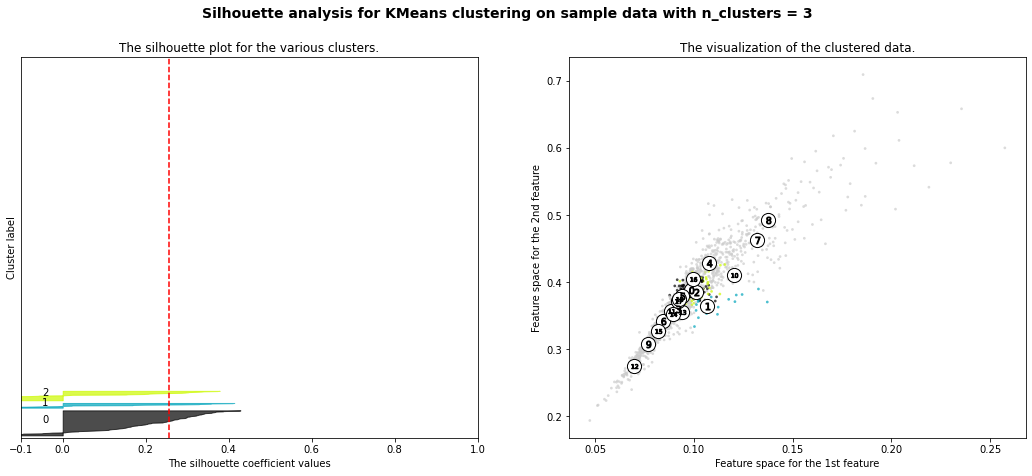

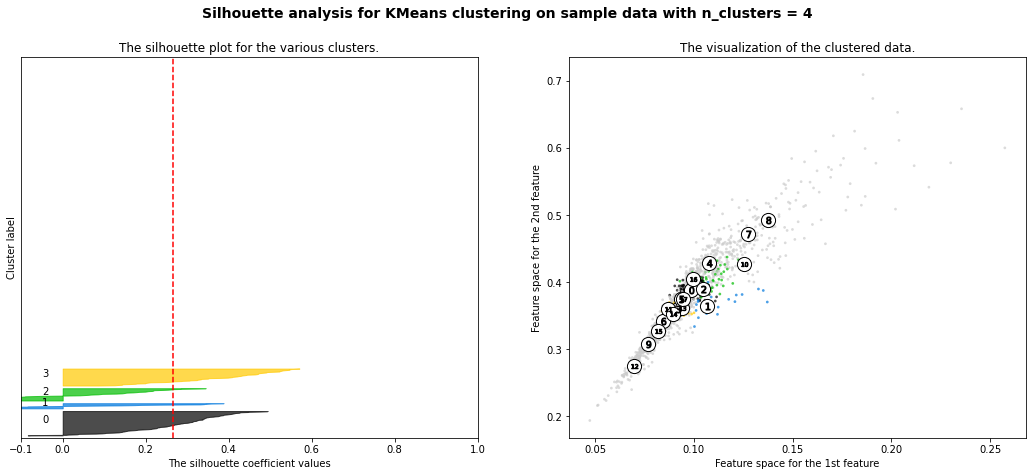

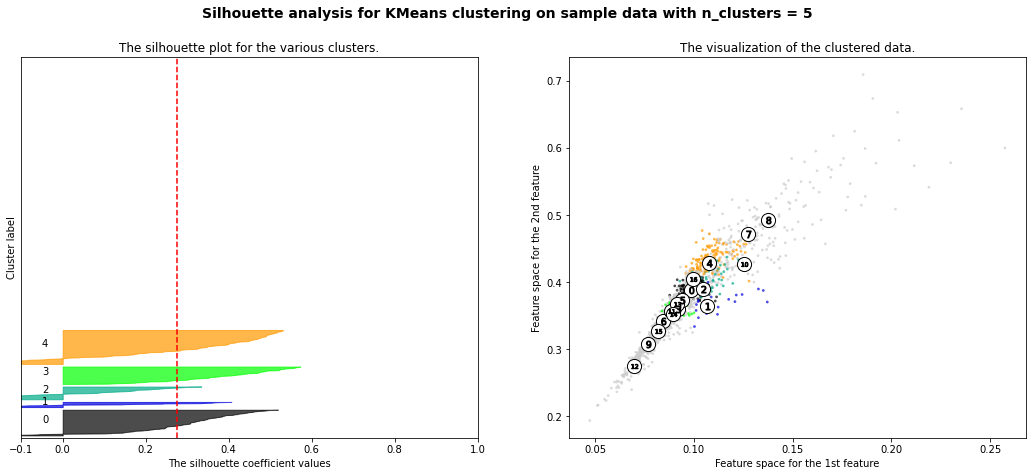

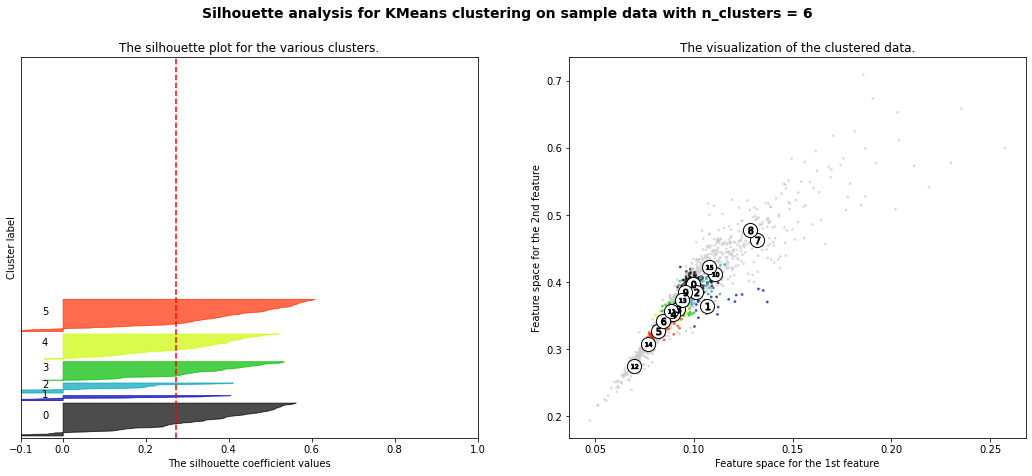

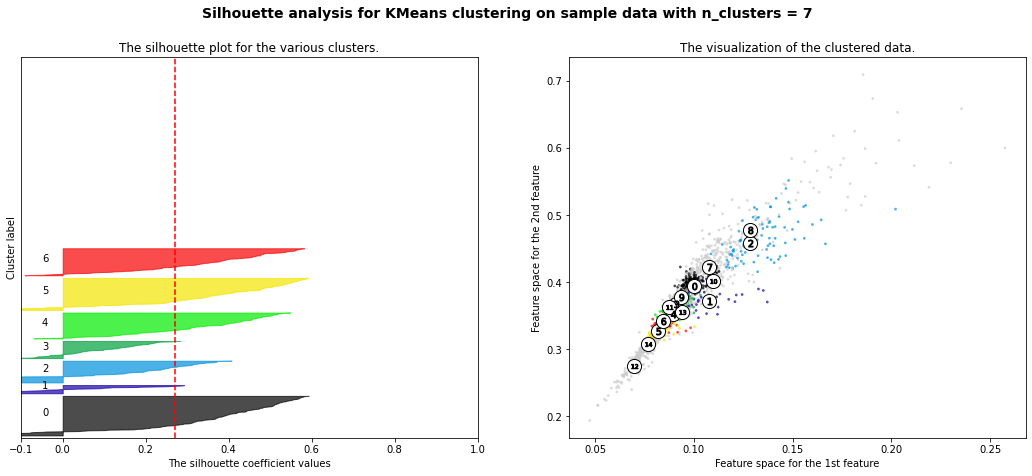

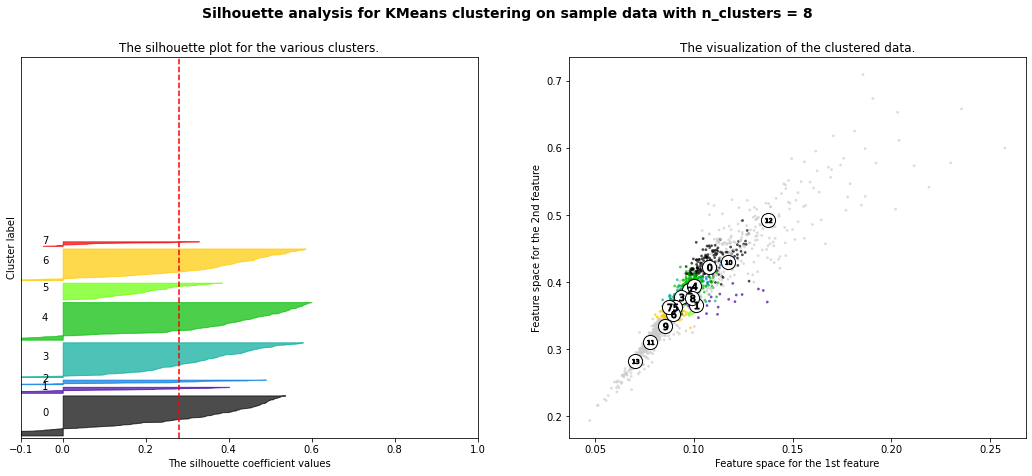

In [55]:

X = np.array(vectorized_docs)
# range_n_clusters = [1,2,3,5,7]
#  for k in range(2,11)
for n_clusters in range(3,9):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMedoids(n_clusters=i, random_state=0,metric='euclidean', init='heuristic')
    cluster_labels = clusterer.fit_predict(X)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels,metric='euclidean',sample_size=1000,random_state=200)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [56]:
from sklearn_extra.cluster import KMedoids

def k_mediods(
	X, 
    k, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    kmedoids = KMedoids(n_clusters=k, random_state=0,metric='euclidean', init='heuristic',).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, kmedoids.labels_):0.2f}")
    print(f"Inertia:{kmedoids.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, kmedoids.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[kmedoids.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
          try:  
              print( 
                    f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
          except ValueError:
            pass
    return kmedoids, kmedoids.labels_

In [57]:
docs = med_data['text_data'].values
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

clustering, cluster_labels = k_mediods(
	X=np.array(vectorized_docs),
    k=15,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 15
Silhouette coefficient: 0.27
Inertia:134.13571166992188
Silhouette values:
    Cluster 14: Size:150 | Avg:0.46 | Min:-0.08 | Max: 0.66
    Cluster 5: Size:134 | Avg:0.35 | Min:-0.18 | Max: 0.59
    Cluster 0: Size:165 | Avg:0.34 | Min:-0.20 | Max: 0.59
    Cluster 6: Size:113 | Avg:0.33 | Min:-0.09 | Max: 0.58
    Cluster 4: Size:108 | Avg:0.33 | Min:-0.07 | Max: 0.55
    Cluster 12: Size:110 | Avg:0.32 | Min:-0.27 | Max: 0.58
    Cluster 7: Size:151 | Avg:0.30 | Min:-0.20 | Max: 0.55
    Cluster 9: Size:154 | Avg:0.30 | Min:-0.15 | Max: 0.54
    Cluster 11: Size:19 | Avg:0.17 | Min:-0.03 | Max: 0.40
    Cluster 10: Size:58 | Avg:0.13 | Min:-0.36 | Max: 0.44
    Cluster 2: Size:91 | Avg:0.11 | Min:-0.33 | Max: 0.41
    Cluster 13: Size:29 | Avg:0.10 | Min:-0.14 | Max: 0.28
    Cluster 3: Size:72 | Avg:0.09 | Min:-0.18 | Max: 0.28
    Cluster 8: Size:111 | Avg:0.02 | Min:-0.45 | Max: 0.34
    Cluster 1: Size:35 | Avg:-0.00 | Min:-0.43 | Max: 0.29


In [58]:
print("Top terms per cluster (based on centroids):")
for i in range(15):
    tokens_per_cluster = ""
    most_representative = Word2Vecmodel.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Top terms per cluster (based on centroids):
Cluster 0: control work system life well 
Cluster 1: techniques technique neuroimaging microscopy agents 
Cluster 2: optical technique pet techniques spect 
Cluster 3: materials general number work due 
Cluster 4: system life work number control 
Cluster 5: number well several head include 
Cluster 6: work number well materials since 
Cluster 7: including provides systems standards work 
Cluster 8: center development diagnostic methods based 
Cluster 9: work number general new well 
Cluster 10: techniques technique scans uses neuroimaging 
Cluster 11: time nerve normal allow inside 
Cluster 12: work general life number materials 
Cluster 13: company procedures manufacturers inc clinical 
Cluster 14: work number materials include life 


In [59]:
test_cluster = 6
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print(docs[d])
    print("-------------")

Splint (medicine),A splint is defined as "a rigid or flexible device that maintains in position a displaced or movable part; also used to keep in place and protect an injured part" or as "a rigid or flexible material used to protect, immobilize, or restrict motion in a part". Splints can be used for injuries that are not severe enough to immobilize the entire injured structure of the body. For instance, a splint can be used for certain fractures, soft tissue sprains, tendon injuries, or injuries awaiting orthopedic treatment. A splint may be static, not allowing motion, or dynamic, allowing controlled motion. Splints can also be used to relieve pain in damaged joints. Splints are quick and easy to apply and do not require a plastering technique. Splints are often made out of some kind of flexible material and a firm pole-like structure for stability. They often buckle or Velcro together.Emergency medical equipment
-------------
Esmarch bandage,Esmarch bandage (also known as Esmarch's b

In [60]:
for i,t in enumerate(df_clusters.query(f"cluster == {test_cluster}").sample(4).iterrows()):
    print(t[1]["text"])
    print("-------------")

Vanderbilt exoskeleton,The Vanderbilt exoskeleton, marketed as Indego, is a powered exoskeleton designed by the Center for Intelligent Mechatronics at Vanderbilt University in the U.S. state of Tennessee. It is intended to assist paraplegics, stroke victims and other paralyzed or semi-paralyzed people to walk independently. Motion and control technologies manufacturer Parker Hannifin is funding further development, and plans to release the first commercial version of the exoskeleton in 2015.Mobility devices
-------------
Signal-averaged electrocardiogram,Signal-averaged electrocardiography (SAECG) is a special electrocardiographic technique, in which multiple electric signals from the heart are averaged to remove interference and reveal small variations in the QRS complex, usually the so-called "late potentials". These may represent a predisposition towards potentially dangerous ventricular tachyarrhythmias.Cardiac electrophysiology
-------------
Gas cabinet,A gas cabinet is a metallic

## Implementation of  heirarchical algorithm

In [67]:
from sklearn.cluster import AgglomerativeClustering
sil =[]
wcss = []
# 'cl_num' is the number of clusters
#  it is completely arbitrary.
cl_num = 15
for i in range(2,cl_num):
    
    agglo = AgglomerativeClustering(n_clusters=i,distance_threshold=None,affinity = "euclidean",linkage='average')
    
    agglo.fit(vectorized_docs)

    labels = agglo.labels_
    sil.append(silhouette_score(vectorized_docs, labels, metric = 'euclidean'))

In [62]:
from sklearn.cluster import AgglomerativeClustering
def agglomerative_clustering(
	X, 
    k, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    agglomerativeclustering = AgglomerativeClustering(n_clusters=k,distance_threshold=None,affinity = "euclidean",linkage='average').fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, agglomerativeclustering.labels_):0.2f}")
    # print(f"Inertia:{agglomerativeclustering.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, agglomerativeclustering.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[agglomerativeclustering.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
          try:  
              print( 
                    f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
          except ValueError:
            pass
    return agglomerativeclustering, agglomerativeclustering.labels_

In [63]:
# docs = new_df['text_data'].values
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

clustering, cluster_labels = agglomerative_clustering(
	X=np.array(vectorized_docs),
    k=20,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    # "cluster": cluster_labels
})

For n_clusters = 20
Silhouette coefficient: 0.36
Silhouette values:
    Cluster 10: Size:3 | Avg:0.67 | Min:0.60 | Max: 0.71
    Cluster 7: Size:3 | Avg:0.66 | Min:0.61 | Max: 0.71
    Cluster 4: Size:12 | Avg:0.59 | Min:0.28 | Max: 0.72
    Cluster 16: Size:4 | Avg:0.56 | Min:0.51 | Max: 0.61
    Cluster 9: Size:93 | Avg:0.55 | Min:-0.27 | Max: 0.75
    Cluster 12: Size:7 | Avg:0.53 | Min:0.31 | Max: 0.65
    Cluster 18: Size:4 | Avg:0.51 | Min:0.49 | Max: 0.55
    Cluster 2: Size:10 | Avg:0.42 | Min:0.18 | Max: 0.61
    Cluster 13: Size:405 | Avg:0.38 | Min:-0.51 | Max: 0.69
    Cluster 3: Size:481 | Avg:0.37 | Min:-0.61 | Max: 0.64
    Cluster 1: Size:319 | Avg:0.32 | Min:-0.48 | Max: 0.59
    Cluster 5: Size:4 | Avg:0.32 | Min:0.19 | Max: 0.41
    Cluster 6: Size:17 | Avg:0.21 | Min:-0.03 | Max: 0.47
    Cluster 0: Size:130 | Avg:0.17 | Min:-0.59 | Max: 0.54
    Cluster 8: Size:3 | Avg:0.04 | Min:-0.05 | Max: 0.12
    Cluster 11: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster

In [70]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

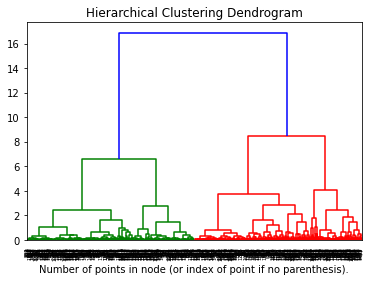

In [75]:
X = X=np.array(vectorized_docs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


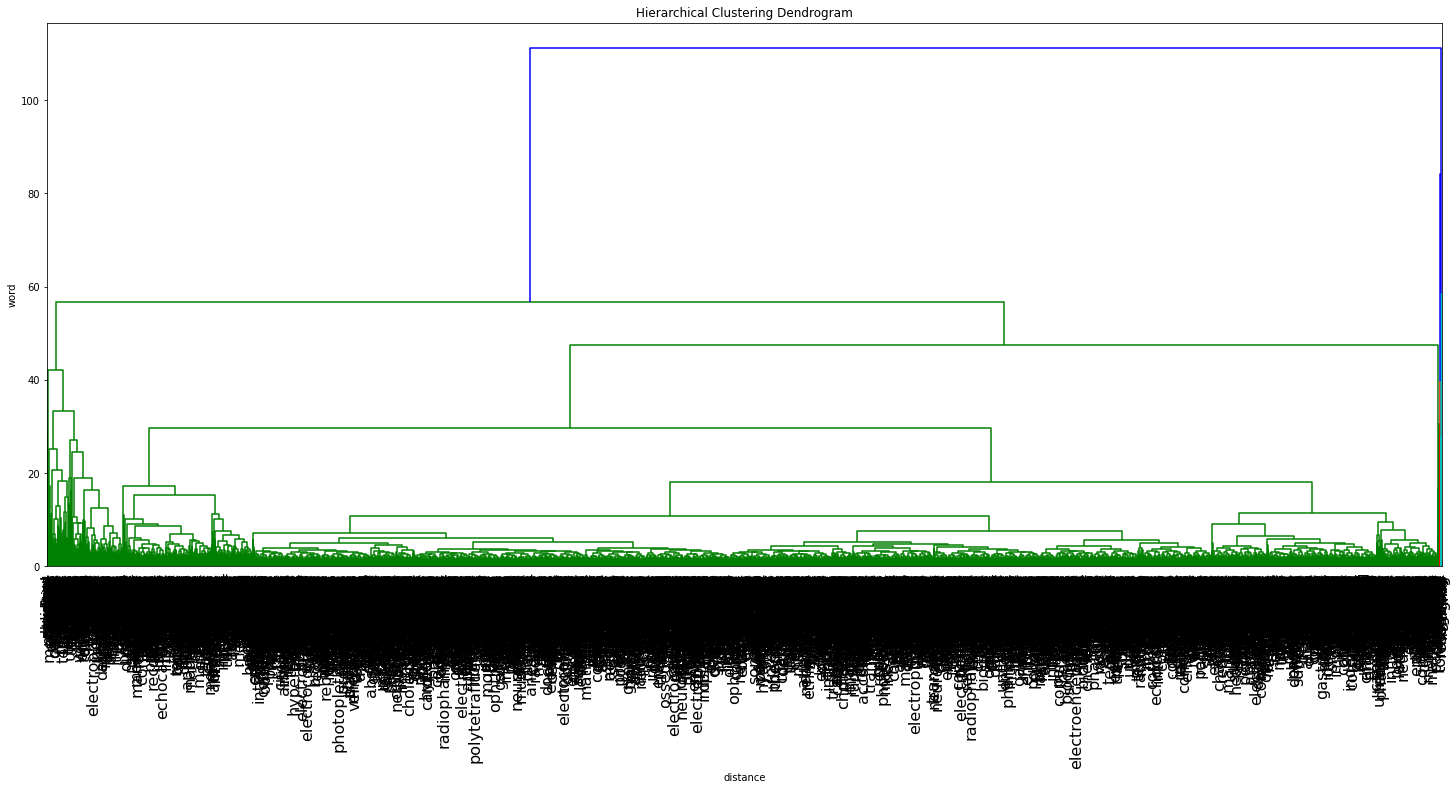

In [68]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

l = linkage(Word2Vecmodel.wv.syn0, method='complete', metric='seuclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
    orientation='top',
    show_leaf_counts ='descending',
    leaf_label_func=lambda v: str(Word2Vecmodel.wv.index2word[v])
)
plt.show()

##DBSCAN

In [76]:
from sklearn.cluster import DBSCAN
def dbscan(
	X,
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    # km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    # dbscan = DBSCAN(n_clusters=k,distance_threshold=None,affinity = "euclidean",linkage='average',compute_distances=True).fit(X)
    db = DBSCAN(eps=0.03, min_samples=15).fit(X)
    labels = db.labels_
    k = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, db.labels_):0.2f}")
    # print(f"Inertia:{agglomerativeclustering.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, db.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[db.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
          try:  
              print( 
                    f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
          except ValueError:
            pass
    return db, db.labels_

In [77]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll

# #############################################################################

X=vectorized_docs
# #############################################################################
# Compute clustering
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=50, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################



# #############################################################################
# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=50, connectivity=connectivity,
                               linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)


Compute unstructured hierarchical clustering...
Elapsed time: 0.13s
Number of points: 1500
Compute structured hierarchical clustering...
Elapsed time: 0.15s
Number of points: 1500


In [78]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [79]:
# Compute DBSCAN
X = np.array(vectorized_docs)
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
      # % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
      # % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 1
Estimated number of noise points: 12
Silhouette Coefficient: 0.649


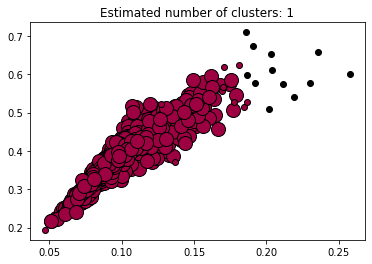

In [80]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Automatically created module for IPython interactive environment
number of estimated clusters : 11


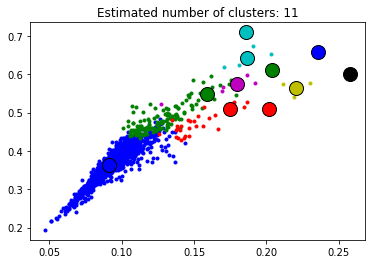

In [81]:
print(__doc__)

import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

# #############################################################################
X =X = np.array(vectorized_docs)

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()